In [3]:
#imports 

import numpy as np
import os, tempfile
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import image_dataset_from_directory 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.dummy import DummyClassifier

import time
import scipy
from scipy import ndimage
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image


## Image Load In

In [4]:
!ls

294.png
371.png
555.png
89.png
AccuracyOverEpochs.png
README.md
Yuhkai_notebook_scratch.ipynb
data
data.zip
notebook.ipynb
notebooks_scratch
saved_models
simple_cnn.pkl


In [33]:
# load in the train data

#starting from main project directory

train_normal_dir = "./data/chest_xray/train/NORMAL"
train_pneumonia_dir = "./data/chest_xray/train/PNEUMONIA"

imgs_train_normal = [file for file in os.listdir(train_normal_dir) if file.endswith('.jpeg')]
imgs_train_pneumonia = [file for file in os.listdir(train_pneumonia_dir) if file.endswith('.jpeg')]

In [34]:
test_normal_dir = "./data/chest_xray/test/NORMAL"
test_pneumonia_dir = "./data/chest_xray/test/PNEUMONIA"

imgs_test_normal = [file for file in os.listdir(test_normal_dir) if file.endswith('.jpeg')]
imgs_test_pneumonia = [file for file in os.listdir(test_pneumonia_dir) if file.endswith('.jpeg')]

In [7]:
len(imgs_train_normal)

1341

In [8]:
len(imgs_train_pneumonia)

3875

In [9]:
imgs_train_normal[0]

'IM-0115-0001.jpeg'

In [10]:
imgs_train_pneumonia[0]

'person1000_bacteria_2931.jpeg'

In [11]:
len(imgs_test_normal)

234

In [12]:
len(imgs_test_pneumonia)

390

In [13]:
num_train = len(imgs_train_normal) + len(imgs_train_pneumonia)
num_test = len(imgs_test_normal) + len(imgs_test_pneumonia)
num_train, num_test

(5216, 624)

In [14]:
ratio_test = 390/num_test
ratio_test

0.625

In [15]:
ratio_train = 3875/num_train
ratio_train

0.7429064417177914

In [35]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [36]:
#rescale images to 64 by 64
#create validation set as 20% of train set

train_folder = "./data/chest_xray/train"
train_gen = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(64, 64), 
        color_mode='grayscale', 
        class_mode='binary',
        subset='training',
        batch_size= num_train,
        seed=64)

validation_gen = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(64, 64), 
        color_mode='grayscale', 
        class_mode='binary',
        subset='validation',
        batch_size= num_train,
        seed=64)

test_folder = "./data/chest_xray/test"
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), color_mode='grayscale', 
        class_mode='binary', 
        batch_size= num_test,
        seed=64)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [37]:
type(train_gen)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [38]:
train_images, train_labels = next(train_gen)
val_images, val_labels = next(validation_gen)
test_images, test_labels = next(test_gen)

In [17]:
train_images[0]

array([[[0.00392157],
        [0.        ],
        [0.01960784],
        ...,
        [0.52156866],
        [0.47058827],
        [0.02352941]],

       [[0.        ],
        [0.        ],
        [0.03921569],
        ...,
        [0.29411766],
        [0.03137255],
        [0.02745098]],

       [[0.        ],
        [0.        ],
        [0.00784314],
        ...,
        [0.03529412],
        [0.427451  ],
        [0.18823531]],

       ...,

       [[0.7686275 ],
        [0.654902  ],
        [0.04705883],
        ...,
        [0.03921569],
        [0.04313726],
        [0.04705883]],

       [[0.8078432 ],
        [0.69411767],
        [0.04313726],
        ...,
        [0.03921569],
        [0.04313726],
        [0.04313726]],

       [[0.7803922 ],
        [0.6313726 ],
        [0.04705883],
        ...,
        [0.03529412],
        [0.03921569],
        [0.04313726]]], dtype=float32)

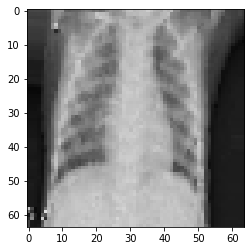

In [105]:
plt.imshow(train_images[0], cmap='gray', vmin=0, vmax=1)

In [233]:
train_folder = "./data/chest_xray/train"
train_unaltered = train_datagen.flow_from_directory(
        train_folder, 
        color_mode='grayscale', 
        class_mode='binary',
        subset='training',
        batch_size= num_train,
        seed=42)


Found 4173 images belonging to 2 classes.


In [234]:
unaltered_images, unaltered_labels = next(train_unaltered)

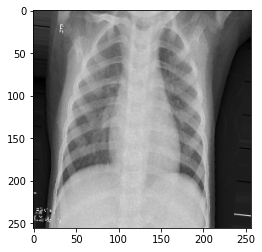

In [113]:
plt.imshow(unaltered_images[0], cmap='gray', vmin=0, vmax=1)

In [242]:
from IPython.display import Image, display

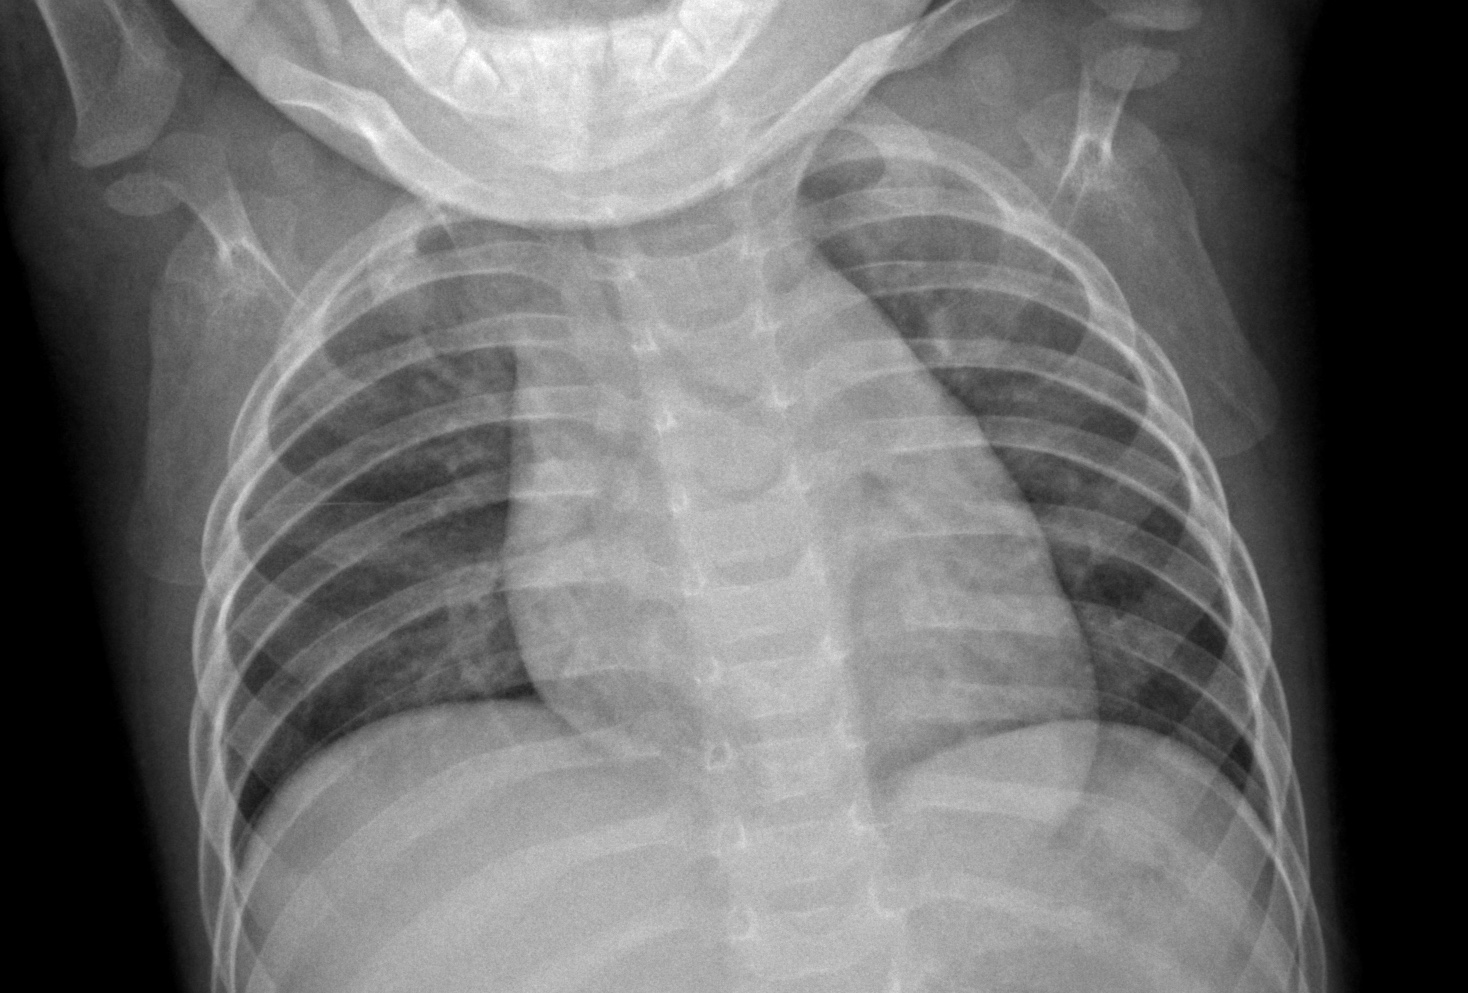

In [243]:
display(Image(filename='./data/chest_xray/train/NORMAL/IM-0133-0001.jpeg'))

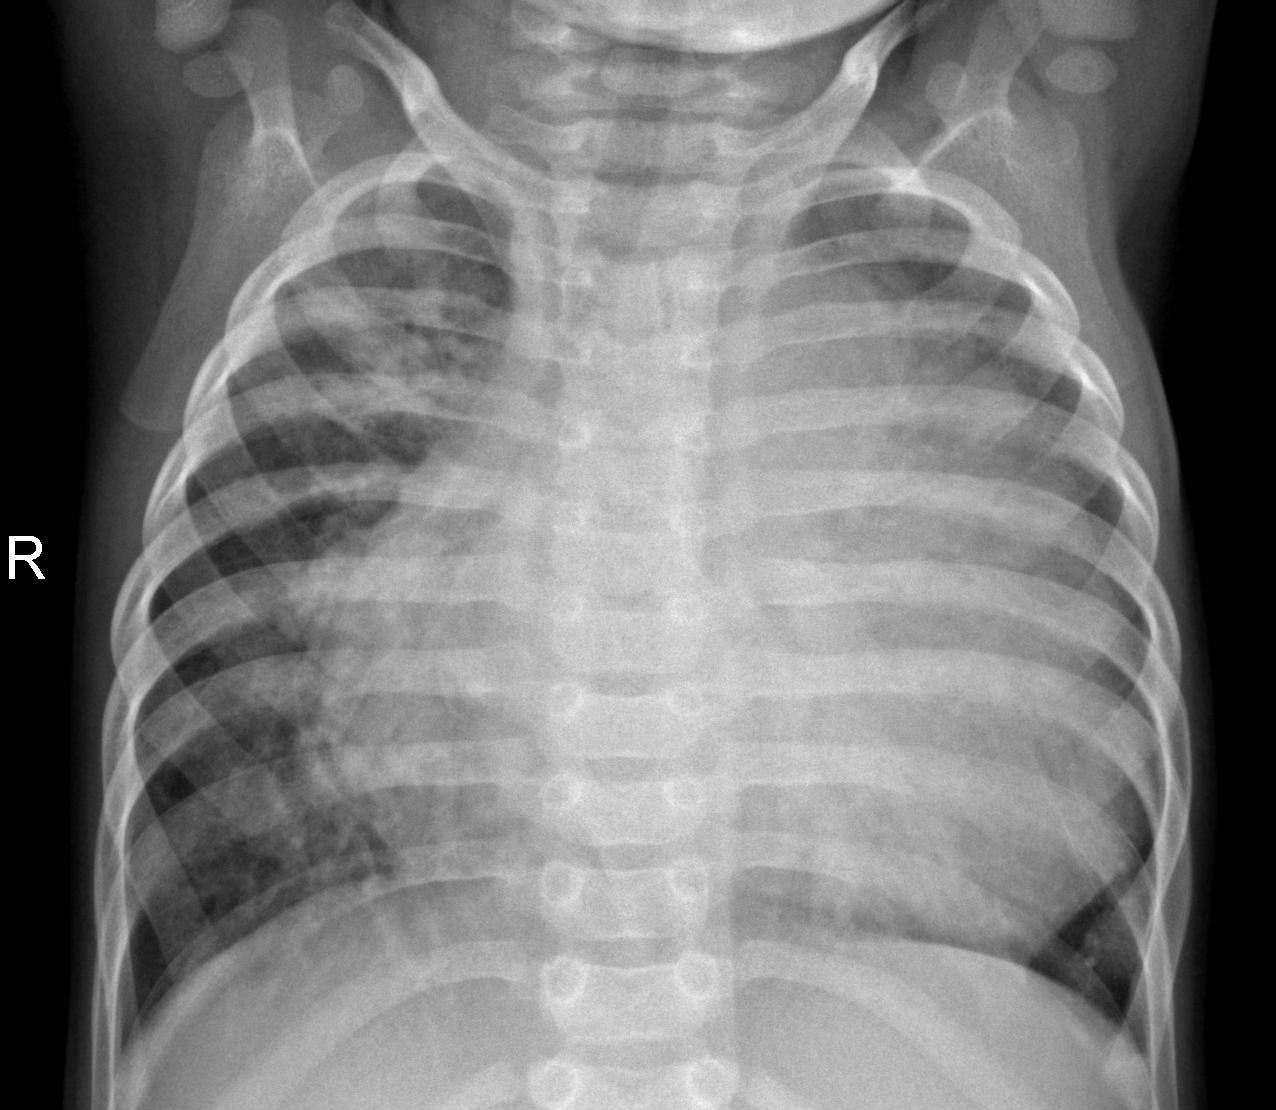

In [251]:
display(Image(filename='./data/chest_xray/train/PNEUMONIA/person5_bacteria_15.jpeg'))

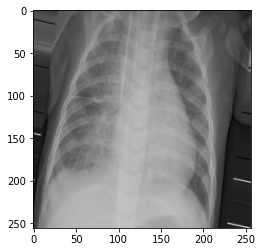

In [237]:
plt.imshow(unaltered_images[10], cmap='gray', vmin=0, vmax=1)

In [114]:
unaltered_labels[0]

0.0

In [19]:
val_images[0]

array([[[0.2627451 ],
        [0.20000002],
        [0.2509804 ],
        ...,
        [0.05882353],
        [0.06666667],
        [0.06666667]],

       [[0.18039216],
        [0.22352943],
        [0.28627452],
        ...,
        [0.11764707],
        [0.04705883],
        [0.0509804 ]],

       [[0.18823531],
        [0.27450982],
        [0.33333334],
        ...,
        [0.21176472],
        [0.14901961],
        [0.03529412]],

       ...,

       [[0.25490198],
        [0.49803925],
        [0.5529412 ],
        ...,
        [0.08235294],
        [0.09803922],
        [0.09019608]],

       [[0.2509804 ],
        [0.49411768],
        [0.5647059 ],
        ...,
        [0.08627451],
        [0.09019608],
        [0.09019608]],

       [[0.27058825],
        [0.4901961 ],
        [0.5921569 ],
        ...,
        [0.09019608],
        [0.10196079],
        [0.09411766]]], dtype=float32)

In [20]:
train_images.shape

(4173, 64, 64, 1)

In [21]:
#(image height, image width, color channels)
train_images[0].shape

(64, 64, 1)

In [22]:
train_labels[0]

1.0

In [23]:
train_labels.shape

(4173,)

In [24]:
val_images.shape

(1043, 64, 64, 1)

In [25]:
val_labels.shape

(1043,)

In [19]:
#reshaping features for dense layers
train_reshape = train_images.reshape(train_images.shape[0], -1)
val_reshape = val_images.reshape(val_images.shape[0], -1)
test_reshape = test_images.reshape(test_images.shape[0], -1)

print(train_reshape.shape)
print(val_reshape.shape)
print(test_reshape.shape)

(4173, 4096)
(1043, 4096)
(624, 4096)


In [20]:
train_labels.shape

(4173,)

In [21]:
val_labels.shape

(1043,)

In [22]:
test_labels.shape

(624,)

In [23]:
#reshaping labels
train_y = np.reshape(train_labels, (4173,1))
val_y = np.reshape(val_labels, (1043,1))
test_y = np.reshape(test_labels, (624,1))

print(train_y.shape)
print(val_y.shape)
print(test_y.shape)

(4173, 1)
(1043, 1)
(624, 1)


# Dummy Classifier

In [31]:
dummy_clf = DummyClassifier()
dummy_clf.fit(train_images, train_labels)
dummy_clf.score(val_images, val_labels)

0.7430488974113135

## Baseline Model

In [39]:
baseline_model = models.Sequential()

In [40]:
baseline_model.add(layers.Dense(20, activation='relu', input_shape=(4096,)))
baseline_model.add(layers.Dense(7, activation='relu'))
baseline_model.add(layers.Dense(5, activation='relu'))
baseline_model.add(layers.Dense(1, activation='sigmoid'))

In [41]:
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                81940     
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 82,133
Trainable params: 82,133
Non-trainable params: 0
_________________________________________________________________


In [42]:
baseline_model.compile(optimizer='sgd', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [43]:
train_reshape[0].shape

(4096,)

In [44]:
val_reshape[0].shape

(4096,)

In [45]:
baseline_model.fit(train_reshape, 
                   train_y, 
                   epochs=50, 
                   batch_size=32, 
                   validation_data=(val_reshape, val_y))

Epoch 1/50
131/131 [==============================] - 1s 6ms/step - loss: 0.5985 - accuracy: 0.7330 - val_loss: 0.5538 - val_accuracy: 0.7430
Epoch 2/50
131/131 [==============================] - 1s 7ms/step - loss: 0.5516 - accuracy: 0.7429 - val_loss: 0.5365 - val_accuracy: 0.7430
Epoch 3/50
131/131 [==============================] - 1s 5ms/step - loss: 0.5100 - accuracy: 0.7429 - val_loss: 0.4717 - val_accuracy: 0.7430
Epoch 4/50
131/131 [==============================] - 1s 6ms/step - loss: 0.4477 - accuracy: 0.7429 - val_loss: 0.4468 - val_accuracy: 0.7430
Epoch 5/50
131/131 [==============================] - 0s 2ms/step - loss: 0.4122 - accuracy: 0.7429 - val_loss: 0.5781 - val_accuracy: 0.7430
Epoch 6/50
131/131 [==============================] - 1s 4ms/step - loss: 0.4059 - accuracy: 0.7877 - val_loss: 0.4018 - val_accuracy: 0.7977
Epoch 7/50
131/131 [==============================] - 0s 3ms/step - loss: 0.3685 - accuracy: 0.8541 - val_loss: 0.4342 - val_accuracy: 0.8092
Epoch 

In [46]:
results_train = baseline_model.evaluate(train_reshape, train_y)
results_train

131/131 [==============================] - 0s 1ms/step - loss: 0.2376 - accuracy: 0.9001


[0.23764273524284363, 0.900071918964386]

In [47]:
results_val = baseline_model.evaluate(val_reshape, val_y)
results_val

33/33 [==============================] - 0s 719us/step - loss: 0.3296 - accuracy: 0.8571


[0.3295828402042389, 0.8571428656578064]

## Convolutional Neural Networks - CNNs

In [37]:
#setting up a simple convolutional model
simple_cnn = models.Sequential()

simple_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', 
          input_shape=(64, 64, 1)))
simple_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
simple_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
#single dense layer
simple_cnn.add(layers.Flatten())
simple_cnn.add(layers.Dense(64, activation='relu'))
#output layer
simple_cnn.add(layers.Dense(1, activation='sigmoid'))

In [38]:
simple_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 53824)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                3444800   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 3,482,433
Trainable params: 3,482,433
Non-trainable params: 0
____________________________________________

In [39]:
simple_cnn.compile(optimizer='sgd',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

In [47]:
simple_cnn.fit(train_images, train_labels, epochs=10, batch_size=400)

Epoch 1/10
11/11 [==============================] - 4s 349ms/step - loss: 0.4689 - accuracy: 0.7985 - recall: 0.9690
Epoch 2/10
11/11 [==============================] - 4s 355ms/step - loss: 0.4162 - accuracy: 0.8308 - recall: 0.9829
Epoch 3/10
11/11 [==============================] - 4s 353ms/step - loss: 0.4301 - accuracy: 0.8160 - recall: 0.9503
Epoch 4/10
11/11 [==============================] - 4s 365ms/step - loss: 0.3959 - accuracy: 0.8397 - recall: 0.9703
Epoch 5/10
11/11 [==============================] - 4s 379ms/step - loss: 0.3704 - accuracy: 0.8519 - recall: 0.9574
Epoch 6/10
11/11 [==============================] - 4s 383ms/step - loss: 0.3993 - accuracy: 0.8390 - recall: 0.9403
Epoch 7/10
11/11 [==============================] - 4s 373ms/step - loss: 0.3415 - accuracy: 0.8622 - recall: 0.9610
Epoch 8/10
11/11 [==============================] - 4s 370ms/step - loss: 0.3802 - accuracy: 0.8308 - recall: 0.9297
Epoch 9/10
11/11 [==============================] - 4s 332ms/ste

In [48]:
simple_cnn_train = simple_cnn.evaluate(train_images, train_labels)
simple_cnn_train

131/131 [==============================] - 2s 11ms/step - loss: 0.3318 - accuracy: 0.8804 - recall: 0.8710


[0.33183497190475464, 0.8804217576980591, 0.8709677457809448]

In [79]:
#this is the  model from day 1 with very good performance in terms of accuracy
simple_cnn_train = simple_cnn.evaluate(train_images, train_labels)
simple_cnn_train

131/131 [==============================] - 4s 22ms/step - loss: 0.2789 - accuracy: 0.9154 - precision: 0.9467


[0.2788931131362915, 0.9154085516929626, 0.9466666579246521]

In [80]:
simple_cnn_val = simple_cnn.evaluate(val_images, val_labels)
simple_cnn_val

33/33 [==============================] - 1s 25ms/step - loss: 0.3074 - accuracy: 0.8859 - precision: 0.9216


[0.30743056535720825, 0.8859060406684875, 0.9215938448905945]

Our first CNN had some overfitting (91% accuracy on the train set and 89% accuracy on the validation set). Precision was also better for the train set (94%) than the validation set (92%).

In [97]:
type(simple_cnn_val)

list

In [31]:
#helper function to store metrics in a dictionary format for easy recall
def metrics_to_dict(model_name, metrics, metrics_dict):
    '''
    Returns a dictionary with model name as key and dictionaries of metrics
    as values
    Nested dictionary has metric names as keys and the scores as values
    
    Takes the following arguments:
    model_name: String of model name
    metrics: list of metric scores from model.evaluate(), must match metric_names
    metrics_dict: dictionary to be added to
    '''
    metrics_dict[model_name]={}
    metric_names = ['loss', 'accuracy', 'precision']
    for i,metric in enumerate(metric_names):
        metrics_dict[model_name][metric] = metrics[i]
    return metrics_dict

In [103]:
metrics_dict = {}
metrics_to_dict('simple_cnn', simple_cnn_val, metrics_dict)
metrics_dict

{'simple_cnn': {'loss': 0.30743056535720825,
  'accuracy': 0.8859060406684875,
  'precision': 0.9215938448905945}}

In [85]:
!ls

README.md
Yuhkai_notebook_scratch.ipynb
data
data.zip
notebooks_scratch
simple_cnn.pkl


In [94]:
#!mkdir saved_models

In [95]:
!ls

-p
README.md
Yuhkai_notebook_scratch.ipynb
data
data.zip
notebooks_scratch
saved_models
simple_cnn.pkl


In [96]:
#saving off the model as pkl file
#simple_cnn.save('saved_models/simple_cnn')

INFO:tensorflow:Assets written to: saved_models/simple_cnn\assets


In [41]:
#loading in pkl file
simple_cnn_loaded = load_model('saved_models/simple_cnn')

In [42]:
#testing loaded pkl file
simple_cnn_loaded.evaluate(val_images, val_labels)

33/33 [==============================] - 4s 29ms/step - loss: 0.3074 - accuracy: 0.8859 - precision: 0.9216


[0.30743053555488586, 0.8859060406684875, 0.9215938448905945]

In [45]:
from sklearn.metrics import recall_score
preds = simple_cnn_loaded.predict(val_images)
preds = np.where(preds > 0.5, 1,0)
preds

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [46]:
recall_score(val_labels, preds)

0.9251612903225807

## Second CNN Model

In [33]:
#second convolutional neural network
second_cnn = models.Sequential()

#adding more convolutional and pooling layers
second_cnn.add(layers.Conv2D(filters=64, kernel_size=(4,4), activation='relu', 
          input_shape=(64, 64, 1)))
second_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
second_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
second_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
second_cnn.add(layers.Conv2D(filters=64, kernel_size=(4,4), activation='relu'))

#two dense layers
second_cnn.add(layers.Flatten())
second_cnn.add(layers.Dense(64, activation='relu'))
second_cnn.add(layers.Dense(64, activation='relu'))
#output layer
second_cnn.add(layers.Dense(1, activation='sigmoid'))

In [34]:
second_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 61, 61, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        65600     
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 64)               

In [35]:
second_cnn.compile(optimizer='sgd',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision()])

In [36]:
second_cnn.fit(train_images, train_labels, epochs=10, batch_size=400)

Epoch 1/10
11/11 [==============================] - 8s 365ms/step - loss: 0.6890 - accuracy: 0.6039 - precision: 0.7557
Epoch 2/10
11/11 [==============================] - 6s 523ms/step - loss: 0.6720 - accuracy: 0.7429 - precision: 0.7429
Epoch 3/10
11/11 [==============================] - 7s 671ms/step - loss: 0.6597 - accuracy: 0.7429 - precision: 0.7429
Epoch 4/10
11/11 [==============================] - 8s 735ms/step - loss: 0.6467 - accuracy: 0.7429 - precision: 0.7429
Epoch 5/10
11/11 [==============================] - 8s 720ms/step - loss: 0.6307 - accuracy: 0.7429 - precision: 0.7429
Epoch 6/10
11/11 [==============================] - 8s 684ms/step - loss: 0.6124 - accuracy: 0.7429 - precision: 0.7429
Epoch 7/10
11/11 [==============================] - 8s 736ms/step - loss: 0.5945 - accuracy: 0.7429 - precision: 0.7429
Epoch 8/10
11/11 [==============================] - 8s 721ms/step - loss: 0.5809 - accuracy: 0.7429 - precision: 0.7429
Epoch 9/10
11/11 [======================

In [ ]:
#ran this second model multiple times, usually got stuck around 0.7429 accuracy

In [118]:
second_cnn.compile(optimizer='sgd',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision()])

In [119]:
second_cnn.fit(train_images, train_labels, epochs=10, batch_size=400)

Epoch 1/10
11/11 [==============================] - 5s 361ms/step - loss: 0.4866 - accuracy: 0.7429 - precision_5: 0.7429
Epoch 2/10
11/11 [==============================] - 4s 362ms/step - loss: 0.4696 - accuracy: 0.7431 - precision_5: 0.7430
Epoch 3/10
11/11 [==============================] - 4s 357ms/step - loss: 0.4597 - accuracy: 0.7525 - precision_5: 0.7502
Epoch 4/10
11/11 [==============================] - 4s 328ms/step - loss: 0.4367 - accuracy: 0.7695 - precision_5: 0.7641
Epoch 5/10
11/11 [==============================] - 4s 327ms/step - loss: 0.4178 - accuracy: 0.8009 - precision_5: 0.7916
Epoch 6/10
11/11 [==============================] - 4s 326ms/step - loss: 0.5014 - accuracy: 0.7985 - precision_5: 0.8149
Epoch 7/10
11/11 [==============================] - 4s 341ms/step - loss: 0.4388 - accuracy: 0.8090 - precision_5: 0.8135
Epoch 8/10
11/11 [==============================] - 4s 334ms/step - loss: 0.3947 - accuracy: 0.8284 - precision_5: 0.8229
Epoch 9/10
11/11 [======

In [123]:
second_cnn_train = second_cnn.evaluate(train_images, train_labels)
second_cnn_train

131/131 [==============================] - 2s 15ms/step - loss: 0.4306 - accuracy: 0.8497 - precision_5: 0.9647


[0.4305930435657501, 0.8497483730316162, 0.9646749496459961]

In [122]:
second_cnn_val = second_cnn.evaluate(val_images, val_labels)
second_cnn_val

33/33 [==============================] - 1s 16ms/step - loss: 0.4541 - accuracy: 0.8150 - precision_5: 0.9491


[0.45411476492881775, 0.8149568438529968, 0.9490740895271301]

This second model has less accuracy (still overfit) but higher precision.

In [125]:
print(len(train_images))
print(len(val_images))

4173
1043


## Grid Search with CNN Model

In [49]:
#setting up a simple convolutional model
GS_cnn = models.Sequential()

GS_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', 
          input_shape=(64, 64, 1)))
GS_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
GS_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
#single dense layer
GS_cnn.add(layers.Flatten())
GS_cnn.add(layers.Dense(64, activation='relu'))
#output layer
GS_cnn.add(layers.Dense(1, activation='sigmoid'))

In [50]:
type(GS_cnn)

tensorflow.python.keras.engine.sequential.Sequential

In [56]:
GS_cnn.compile(optimizer='sgd',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

In [55]:
type(GS_cnn)

tensorflow.python.keras.engine.sequential.Sequential

In [59]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def build_classifier():
    model = models.Sequential()
    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', 
          input_shape=(64, 64, 1)))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
#single dense layer
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
#output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='sgd',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])
    return model

In [60]:
GS_cnn = KerasClassifier(build_classifier, verbose=0)

In [74]:
batch_size = [100, 200, 400, 1000]
epochs = [10, 20, 30]
#early_stop = [EarlyStopping(monitor='loss', min_delta=1e-3, verbose=1, mode='min')]

param_grid = dict(batch_size=batch_size, epochs=epochs, callbacks=[early_stop])


In [75]:
grid = GridSearchCV(estimator=GS_cnn, param_grid=param_grid, cv=3, verbose=3)

In [76]:
grid_results = grid.fit(train_images, train_labels)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END batch_size=100, callbacks=[<tensorflow.python.keras.callbacks.EarlyStopping object at 0x00000213C8A00AF0>], epochs=10;, score=0.735 total time=   4.7s
[CV 2/3] END batch_size=100, callbacks=[<tensorflow.python.keras.callbacks.EarlyStopping object at 0x00000213C8A00AF0>], epochs=10;, score=0.756 total time=   4.9s
[CV 3/3] END batch_size=100, callbacks=[<tensorflow.python.keras.callbacks.EarlyStopping object at 0x00000213C8A00AF0>], epochs=10;, score=0.738 total time=   5.0s
[CV 1/3] END batch_size=100, callbacks=[<tensorflow.python.keras.callbacks.EarlyStopping object at 0x00000213C8A00AF0>], epochs=20;, score=0.735 total time=   5.1s
[CV 2/3] END batch_size=100, callbacks=[<tensorflow.python.keras.callbacks.EarlyStopping object at 0x00000213C8A00AF0>], epochs=20;, score=0.756 total time=   5.2s
[CV 3/3] END batch_size=100, callbacks=[<tensorflow.python.keras.callbacks.EarlyStopping object at 0x00000213C8A00AF0>]

In [77]:
grid_results.best_params_

{'batch_size': 100,
 'callbacks': [<tensorflow.python.keras.callbacks.EarlyStopping at 0x213c8a00af0>],
 'epochs': 10}

In [78]:
grid_results.best_score_

0.74287082751592

In [79]:
type(simple_cnn_loaded)

tensorflow.python.keras.engine.sequential.Sequential

In [82]:
simple_cnn_loaded.compile(optimizer='sgd',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

In [83]:
simple_cnn_loaded.evaluate(val_images, val_labels)

33/33 [==============================] - 1s 15ms/step - loss: 0.3074 - accuracy: 0.8859 - recall_84: 0.9252


[0.30743053555488586, 0.8859060406684875, 0.9251613020896912]

## More CNN modeling

In [50]:
third_cnn = models.Sequential()

third_cnn.add(layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu', 
          input_shape=(64, 64, 1)))
third_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
third_cnn.add(layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu'))
third_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
third_cnn.add(layers.Conv2D(filters=128, kernel_size=(2,2), activation='relu'))
third_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
#single dense layer
third_cnn.add(layers.Flatten())
third_cnn.add(layers.Dense(64, activation='relu'))
#output layer
third_cnn.add(layers.Dense(1, activation='sigmoid'))

In [51]:
third_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 63, 63, 32)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       32896     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [52]:
third_cnn.compile(optimizer='sgd',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision()])

In [54]:
third_cnn.fit(train_images, train_labels, epochs=20, batch_size=30, validation_data=(val_images, val_labels))

Epoch 1/20
140/140 [==============================] - 10s 69ms/step - loss: 0.5398 - accuracy: 0.7429 - precision_2: 0.7429 - val_loss: 0.5794 - val_accuracy: 0.7622 - val_precision_2: 0.7581
Epoch 2/20
140/140 [==============================] - 9s 62ms/step - loss: 0.5000 - accuracy: 0.7510 - precision_2: 0.7492 - val_loss: 0.4788 - val_accuracy: 0.7776 - val_precision_2: 0.7712
Epoch 3/20
140/140 [==============================] - 8s 59ms/step - loss: 0.4306 - accuracy: 0.7977 - precision_2: 0.7976 - val_loss: 0.4364 - val_accuracy: 0.7555 - val_precision_2: 0.7529
Epoch 4/20
140/140 [==============================] - 9s 64ms/step - loss: 0.3711 - accuracy: 0.8387 - precision_2: 0.8531 - val_loss: 0.5439 - val_accuracy: 0.7498 - val_precision_2: 0.7485
Epoch 5/20
140/140 [==============================] - 10s 74ms/step - loss: 0.2961 - accuracy: 0.8790 - precision_2: 0.8947 - val_loss: 2.0909 - val_accuracy: 0.2742 - val_precision_2: 1.0000
Epoch 6/20
140/140 [=======================

In [55]:
third_cnn.evaluate(train_images, train_labels)

131/131 [==============================] - 1s 6ms/step - loss: 0.1205 - accuracy: 0.9511 - precision_2: 0.9500


[0.12046554684638977, 0.951114296913147, 0.9499689340591431]

In [56]:
third_cnn.evaluate(val_images, val_labels)

33/33 [==============================] - 0s 8ms/step - loss: 0.1343 - accuracy: 0.9386 - precision_2: 0.9427


[0.13427318632602692, 0.9386385679244995, 0.9427148103713989]

In [139]:
#third_cnn.save('saved_models/third_cnn_2')

INFO:tensorflow:Assets written to: saved_models/third_cnn_2\assets


In [124]:
third_cnn_loaded = load_model('saved_models/third_cnn')

In [125]:
third_cnn_loaded.summary()

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_178 (Conv2D)          (None, 63, 63, 32)        160       
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 30, 30, 64)        8256      
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 11, 14, 128)       82048     
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 5, 7, 128)         0         
_________________________________________________________________
flatten_87 (Flatten)         (None, 4480)            

In [135]:
third_cnn_loaded.evaluate(train_images, train_labels)

131/131 [==============================] - 1s 5ms/step - loss: 0.1771 - accuracy: 0.9291 - precision_3: 0.9354


[0.1771456003189087, 0.9290677905082703, 0.9354037046432495]

In [148]:
third_cnn_loaded.evaluate(val_images, val_labels)

33/33 [==============================] - 0s 5ms/step - loss: 0.2020 - accuracy: 0.9147 - precision_3: 0.9235


[0.2019975781440735, 0.9146692156791687, 0.9234567880630493]

In [34]:
third_cnn_2=load_model('saved_models/third_cnn_2')

In [36]:
third_cnn_2.evaluate(train_images, train_labels)

131/131 [==============================] - 1s 4ms/step - loss: 0.1219 - accuracy: 0.9540 - precision_8: 0.9783


[0.12193672358989716, 0.9539899230003357, 0.9782894849777222]

In [37]:
third_cnn_2.evaluate(val_images, val_labels)

33/33 [==============================] - 0s 7ms/step - loss: 0.1530 - accuracy: 0.9406 - precision_8: 0.9785


[0.1530119925737381, 0.9405561089515686, 0.9785234928131104]

## Adjusting third model

In [120]:
fourth_cnn = models.Sequential()

fourth_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', 
          input_shape=(64, 64, 1)))
fourth_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
fourth_cnn.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
fourth_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
fourth_cnn.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
fourth_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
#two dense layers
fourth_cnn.add(layers.Flatten())
fourth_cnn.add(layers.Dense(64, activation='relu'))
fourth_cnn.add(layers.Dense(64, activation='relu'))
#output layer
fourth_cnn.add(layers.Dense(1, activation='sigmoid'))

In [121]:
fourth_cnn.summary()

Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_196 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_197 (Conv2D)          (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_198 (Conv2D)          (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_93 (Flatten)         (None, 4608)            

In [122]:
fourth_cnn.compile(optimizer='sgd',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision()])

In [130]:
fourth_cnn.fit(train_images, train_labels, epochs=10, batch_size=200, validation_data=(val_images, val_labels))

Epoch 1/10
21/21 [==============================] - 6s 298ms/step - loss: 0.5756 - accuracy: 0.7429 - precision_6: 0.7429 - val_loss: 0.5682 - val_accuracy: 0.7430 - val_precision_6: 0.7430
Epoch 2/10
21/21 [==============================] - 6s 300ms/step - loss: 0.5743 - accuracy: 0.7429 - precision_6: 0.7429 - val_loss: 0.5666 - val_accuracy: 0.7430 - val_precision_6: 0.7430
Epoch 3/10
21/21 [==============================] - 6s 301ms/step - loss: 0.5729 - accuracy: 0.7429 - precision_6: 0.7429 - val_loss: 0.5654 - val_accuracy: 0.7430 - val_precision_6: 0.7430
Epoch 4/10
21/21 [==============================] - 6s 295ms/step - loss: 0.5718 - accuracy: 0.7429 - precision_6: 0.7429 - val_loss: 0.5644 - val_accuracy: 0.7430 - val_precision_6: 0.7430
Epoch 5/10
21/21 [==============================] - 6s 303ms/step - loss: 0.5706 - accuracy: 0.7429 - precision_6: 0.7429 - val_loss: 0.5632 - val_accuracy: 0.7430 - val_precision_6: 0.7430
Epoch 6/10
21/21 [==============================] 

## Data Augmentation

In [14]:
imgs_train_normal

['IM-0115-0001.jpeg',
 'IM-0117-0001.jpeg',
 'IM-0119-0001.jpeg',
 'IM-0122-0001.jpeg',
 'IM-0125-0001.jpeg',
 'IM-0127-0001.jpeg',
 'IM-0128-0001.jpeg',
 'IM-0129-0001.jpeg',
 'IM-0131-0001.jpeg',
 'IM-0133-0001.jpeg',
 'IM-0135-0001.jpeg',
 'IM-0137-0001.jpeg',
 'IM-0140-0001.jpeg',
 'IM-0141-0001.jpeg',
 'IM-0143-0001.jpeg',
 'IM-0145-0001.jpeg',
 'IM-0147-0001.jpeg',
 'IM-0149-0001.jpeg',
 'IM-0151-0001.jpeg',
 'IM-0152-0001.jpeg',
 'IM-0154-0001.jpeg',
 'IM-0156-0001.jpeg',
 'IM-0158-0001.jpeg',
 'IM-0160-0001.jpeg',
 'IM-0162-0001.jpeg',
 'IM-0164-0001.jpeg',
 'IM-0166-0001.jpeg',
 'IM-0168-0001.jpeg',
 'IM-0170-0001.jpeg',
 'IM-0172-0001.jpeg',
 'IM-0176-0001.jpeg',
 'IM-0177-0001.jpeg',
 'IM-0178-0001.jpeg',
 'IM-0180-0001.jpeg',
 'IM-0182-0001.jpeg',
 'IM-0183-0001.jpeg',
 'IM-0185-0001.jpeg',
 'IM-0187-0001.jpeg',
 'IM-0189-0001.jpeg',
 'IM-0191-0001.jpeg',
 'IM-0193-0001.jpeg',
 'IM-0195-0001.jpeg',
 'IM-0199-0001.jpeg',
 'IM-0201-0001.jpeg',
 'IM-0203-0001.jpeg',
 'IM-0205-

In [16]:
#create image data generator for train data
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range = 30,
                                   shear_range = 0.2, 
                                   zoom_range = 0.2,
                                   validation_split=0.2)

In [17]:
#rescale images to 64 by 64
#create validation set as 20% of train set

train_folder = "./data/chest_xray/train"
train_gen = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(64, 64), 
        color_mode='grayscale', 
        class_mode='binary',
        subset='training',
        batch_size= num_train, seed=42)

validation_gen = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(64, 64), 
        color_mode='grayscale', 
        class_mode='binary',
        subset='validation',
        batch_size= num_train, seed=42)

test_folder = "./data/chest_xray/test"
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), color_mode='grayscale', 
        class_mode='binary', 
        batch_size= num_test)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [18]:
train_images, train_labels = next(train_gen)
val_images, val_labels = next(validation_gen)
test_images, test_labels = next(test_gen)

In [21]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, mode = 'min')

In [178]:
fifth_cnn = models.Sequential()

fifth_cnn.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', 
          input_shape=(64, 64, 1)))
fifth_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
fifth_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
fifth_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
fifth_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
fifth_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
#two dense layers
fifth_cnn.add(layers.Flatten())
fifth_cnn.add(layers.Dense(64, activation='relu'))
fifth_cnn.add(layers.Dropout(0.5))
fifth_cnn.add(layers.Dense(64, activation='relu'))
#output layer
fifth_cnn.add(layers.Dense(1, activation='sigmoid'))

In [179]:
fifth_cnn.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 4096)            

In [180]:
fifth_cnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

In [181]:
fifth_cnn.fit(train_images, train_labels, epochs=30, batch_size=200, validation_data=(val_images, val_labels))

Epoch 1/30
21/21 [==============================] - 5s 210ms/step - loss: 0.6019 - accuracy: 0.7256 - recall_26: 0.9639 - val_loss: 0.5640 - val_accuracy: 0.7430 - val_recall_26: 1.0000
Epoch 2/30
21/21 [==============================] - 4s 179ms/step - loss: 0.5676 - accuracy: 0.7429 - recall_26: 1.0000 - val_loss: 0.5274 - val_accuracy: 0.7430 - val_recall_26: 1.0000
Epoch 3/30
21/21 [==============================] - 4s 185ms/step - loss: 0.4836 - accuracy: 0.7592 - recall_26: 0.9887 - val_loss: 0.4268 - val_accuracy: 0.8274 - val_recall_26: 0.8671
Epoch 4/30
21/21 [==============================] - 4s 186ms/step - loss: 0.3855 - accuracy: 0.8143 - recall_26: 0.9339 - val_loss: 0.3673 - val_accuracy: 0.8418 - val_recall_26: 0.9781
Epoch 5/30
21/21 [==============================] - 4s 185ms/step - loss: 0.2978 - accuracy: 0.8665 - recall_26: 0.9435 - val_loss: 0.3133 - val_accuracy: 0.8782 - val_recall_26: 0.9561
Epoch 6/30
21/21 [==============================] - 4s 188ms/step - lo

In [182]:
fifth_cnn.evaluate(train_images, train_labels)

131/131 [==============================] - 2s 14ms/step - loss: 0.0753 - accuracy: 0.9744 - recall_26: 0.9929


[0.07527176290750504, 0.9743589758872986, 0.9929032325744629]

In [183]:
fifth_cnn.evaluate(val_images, val_labels)

33/33 [==============================] - 0s 13ms/step - loss: 0.1854 - accuracy: 0.9406 - recall_26: 0.9665


[0.18539607524871826, 0.9405561089515686, 0.9664515852928162]

In [184]:
fifth_cnn.evaluate(test_images, test_labels)

20/20 [==============================] - 0s 11ms/step - loss: 0.4291 - accuracy: 0.8910 - recall_26: 0.9846


[0.42905694246292114, 0.8910256624221802, 0.9846153855323792]

In [207]:
fifth_cnn.save('saved_models/fifth_cnn')

INFO:tensorflow:Assets written to: saved_models/fifth_cnn\assets


In [217]:
from sklearn.metrics import recall_score
preds = fifth_cnn.predict(test_images)
preds

array([[0.99999964],
       [1.        ],
       [0.76539814],
       [0.83299387],
       [0.99998784],
       [0.99865305],
       [0.9886999 ],
       [0.1615467 ],
       [1.        ],
       [0.08703321],
       [0.999926  ],
       [0.04962799],
       [0.04608256],
       [0.09688023],
       [0.17663461],
       [0.6365896 ],
       [0.99999183],
       [0.9999667 ],
       [1.        ],
       [0.08427915],
       [0.9995376 ],
       [0.05799788],
       [0.99953264],
       [0.07700822],
       [0.10081929],
       [0.7836153 ],
       [0.3364153 ],
       [0.84549737],
       [0.04629427],
       [0.01678923],
       [0.99869144],
       [1.        ],
       [0.9917552 ],
       [0.9999964 ],
       [0.03822976],
       [0.9826939 ],
       [1.        ],
       [0.99998355],
       [0.9998897 ],
       [1.        ],
       [0.9989959 ],
       [1.        ],
       [0.1101324 ],
       [0.99318707],
       [0.99997616],
       [0.9999974 ],
       [1.        ],
       [0.999

In [218]:
pred_labels = np.where(preds > 0.5, 1,0)
pred_labels

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
    

In [214]:
val_labels

array([1., 1., 1., ..., 1., 0., 1.], dtype=float32)

In [224]:
def compare_labels(preds, labels, category):
    mispredicted = []
    for i in range(len(labels)):
        if preds[i] != labels[i] and labels[i] == category:
            mispredicted.append(i)
    return mispredicted

In [226]:
test_mispredicted = compare_labels(pred_labels, test_labels, 1)

In [227]:
len(test_mispredicted)

6

In [228]:
len(test_labels)

624

In [229]:
6/624

0.009615384615384616

In [195]:
sixth_cnn = models.Sequential()

sixth_cnn.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', 
          input_shape=(64, 64, 1)))
sixth_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
sixth_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', 
                           kernel_regularizer= l2(l=0.001)))
sixth_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
sixth_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', 
                           kernel_regularizer= l2(l=0.001)))
sixth_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
#two dense layers
sixth_cnn.add(layers.Flatten())
sixth_cnn.add(layers.Dense(64, activation='relu'))
sixth_cnn.add(layers.Dropout(0.5))
sixth_cnn.add(layers.Dense(64, activation='relu'))
#output layer
sixth_cnn.add(layers.Dense(1, activation='sigmoid'))

In [196]:
sixth_cnn.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 4096)            

In [197]:
sixth_cnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

In [198]:
sixth_cnn.fit(train_images, train_labels, epochs=30, batch_size=200, validation_data=(val_images, val_labels))

Epoch 1/30
21/21 [==============================] - 5s 216ms/step - loss: 0.6846 - accuracy: 0.7314 - recall_29: 0.9748 - val_loss: 0.6352 - val_accuracy: 0.7430 - val_recall_29: 1.0000
Epoch 2/30
21/21 [==============================] - 2s 112ms/step - loss: 0.6176 - accuracy: 0.7429 - recall_29: 1.0000 - val_loss: 0.5517 - val_accuracy: 0.7430 - val_recall_29: 1.0000
Epoch 3/30
21/21 [==============================] - 2s 106ms/step - loss: 0.4931 - accuracy: 0.7429 - recall_29: 1.0000 - val_loss: 0.4371 - val_accuracy: 0.7430 - val_recall_29: 1.0000
Epoch 4/30
21/21 [==============================] - 2s 109ms/step - loss: 0.4018 - accuracy: 0.7429 - recall_29: 1.0000 - val_loss: 0.4368 - val_accuracy: 0.8035 - val_recall_29: 0.9884
Epoch 5/30
21/21 [==============================] - 2s 107ms/step - loss: 0.3729 - accuracy: 0.8680 - recall_29: 0.9532 - val_loss: 0.3661 - val_accuracy: 0.8533 - val_recall_29: 0.9639
Epoch 6/30
21/21 [==============================] - 2s 107ms/step - lo

In [201]:
sixth_cnn.evaluate(train_images, train_labels)

131/131 [==============================] - 1s 11ms/step - loss: 0.1276 - accuracy: 0.9638 - recall_29: 0.9613


[0.1275678426027298, 0.9638149738311768, 0.9612902998924255]

In [202]:
sixth_cnn.evaluate(val_images, val_labels)

33/33 [==============================] - 0s 11ms/step - loss: 0.2041 - accuracy: 0.9243 - recall_29: 0.9148


[0.20408937335014343, 0.9242569804191589, 0.9148387312889099]

In [203]:
seventh_cnn = models.Sequential()

seventh_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', 
          input_shape=(64, 64, 1)))
seventh_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
seventh_cnn.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', 
                              kernel_regularizer= l2(l=0.01)))
seventh_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
seventh_cnn.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', 
                              kernel_regularizer= l2(l=0.1)))
seventh_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
#two dense layers
seventh_cnn.add(layers.Flatten())
seventh_cnn.add(layers.Dense(64, activation='relu'))
seventh_cnn.add(layers.Dropout(0.5))
seventh_cnn.add(layers.Dense(64, activation='relu'))
#output layer
seventh_cnn.add(layers.Dense(1, activation='sigmoid'))

In [204]:
seventh_cnn.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 4096)            

In [205]:
seventh_cnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

In [206]:
seventh_cnn.fit(train_images, train_labels, epochs=30, batch_size=100, validation_data=(val_images, val_labels))

Epoch 1/30
42/42 [==============================] - 7s 141ms/step - loss: 1.2528 - accuracy: 0.7426 - recall_30: 0.9997 - val_loss: 0.8341 - val_accuracy: 0.7430 - val_recall_30: 1.0000
Epoch 2/30
42/42 [==============================] - 5s 128ms/step - loss: 0.7042 - accuracy: 0.7429 - recall_30: 1.0000 - val_loss: 0.6282 - val_accuracy: 0.7430 - val_recall_30: 1.0000
Epoch 3/30
42/42 [==============================] - 5s 128ms/step - loss: 0.6034 - accuracy: 0.7429 - recall_30: 1.0000 - val_loss: 0.5451 - val_accuracy: 0.7430 - val_recall_30: 1.0000
Epoch 4/30
42/42 [==============================] - 7s 162ms/step - loss: 0.4906 - accuracy: 0.7429 - recall_30: 1.0000 - val_loss: 0.4537 - val_accuracy: 0.7430 - val_recall_30: 1.0000
Epoch 5/30
42/42 [==============================] - 7s 173ms/step - loss: 0.4016 - accuracy: 0.7793 - recall_30: 0.9906 - val_loss: 0.4052 - val_accuracy: 0.8293 - val_recall_30: 0.9755
Epoch 6/30
42/42 [==============================] - 7s 174ms/step - lo

In [208]:
seventh_cnn.evaluate(train_images, train_labels)

131/131 [==============================] - 2s 16ms/step - loss: 0.1597 - accuracy: 0.9530 - recall_30: 0.9584


[0.15971247851848602, 0.9530314207077026, 0.9583870768547058]

In [209]:
seventh_cnn.evaluate(val_images, val_labels)

33/33 [==============================] - 0s 12ms/step - loss: 0.2164 - accuracy: 0.9214 - recall_30: 0.9342


[0.21643875539302826, 0.9213806390762329, 0.9341935515403748]

In [363]:
eighth_cnn = models.Sequential()

eighth_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', 
          input_shape=(64, 64, 1)))
eighth_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
eighth_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', 
                              kernel_regularizer= l2(l=0.001)))
eighth_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
#single dense layers
eighth_cnn.add(layers.Flatten())
eighth_cnn.add(layers.Dropout(0.5))
eighth_cnn.add(layers.Dense(64, activation='relu'))
#output layer
eighth_cnn.add(layers.Dense(1, activation='sigmoid'))

In [364]:
eighth_cnn.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 16384)             0         
_________________________________________________________________
dense_88 (Dense)             (None, 64)              

In [39]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=8, mode = 'min')

In [366]:
eighth_cnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

In [367]:
eighth_cnn = eighth_cnn.fit(train_images, train_labels, epochs=30, batch_size=100, validation_data=(val_images, val_labels), callbacks=[earlystop])

Epoch 1/30
42/42 [==============================] - 6s 129ms/step - loss: 0.5622 - accuracy: 0.7474 - recall_32: 0.9719 - val_loss: 0.4318 - val_accuracy: 0.8035 - val_recall_32: 0.9819
Epoch 2/30
42/42 [==============================] - 6s 139ms/step - loss: 0.4165 - accuracy: 0.8291 - recall_32: 0.9300 - val_loss: 0.3804 - val_accuracy: 0.8447 - val_recall_32: 0.9652
Epoch 3/30
42/42 [==============================] - 6s 140ms/step - loss: 0.3042 - accuracy: 0.8886 - recall_32: 0.9374 - val_loss: 0.3116 - val_accuracy: 0.8830 - val_recall_32: 0.9523
Epoch 4/30
42/42 [==============================] - 6s 143ms/step - loss: 0.2935 - accuracy: 0.8869 - recall_32: 0.9365 - val_loss: 0.3834 - val_accuracy: 0.8418 - val_recall_32: 0.8232
Epoch 5/30
42/42 [==============================] - 6s 142ms/step - loss: 0.2610 - accuracy: 0.9034 - recall_32: 0.9442 - val_loss: 0.2805 - val_accuracy: 0.8936 - val_recall_32: 0.9342
Epoch 6/30
42/42 [==============================] - 6s 143ms/step - lo

In [348]:
eighth_cnn.evaluate(train_images, train_labels)

131/131 [==============================] - 2s 13ms/step - loss: 0.1345 - accuracy: 0.9835 - recall_6: 0.9913


[0.13448096811771393, 0.9834651350975037, 0.9912903308868408]

In [349]:
eighth_cnn.evaluate(val_images, val_labels)

33/33 [==============================] - 0s 10ms/step - loss: 0.2226 - accuracy: 0.9453 - recall_6: 0.9729


[0.22258830070495605, 0.945349931716919, 0.9729032516479492]

In [351]:
eighth_cnn.evaluate(test_images, test_labels)

20/20 [==============================] - 0s 9ms/step - loss: 0.4346 - accuracy: 0.8846 - recall_6: 0.9897


[0.43460190296173096, 0.8846153616905212, 0.9897435903549194]

In [ ]:
#eighth_cnn.save('saved_models/eighth_cnn')

In [358]:
eighth_cnn_loaded = load_model('saved_models/eighth_cnn')

In [360]:
type(eighth_cnn_loaded)

tensorflow.python.keras.engine.sequential.Sequential

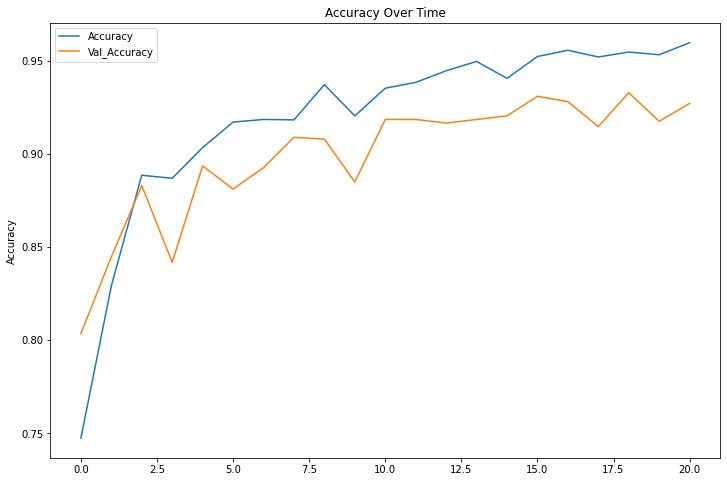

In [373]:
plt.figure(figsize=(12, 8))
plt.plot(eighth_cnn.history['accuracy'], label='Accuracy')
plt.plot(eighth_cnn.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Over Time')
plt.ylabel('Accuracy')
plt.savefig('AccuracyOverEpochs.png', dpi=300)

In [313]:
preds = eighth_cnn.predict(test_images)
preds

array([[1.        ],
       [1.        ],
       [0.2969868 ],
       [0.4372157 ],
       [0.99998486],
       [0.998623  ],
       [0.9450733 ],
       [0.3950833 ],
       [1.        ],
       [0.2719134 ],
       [0.9983975 ],
       [0.2719134 ],
       [0.27911407],
       [0.2719134 ],
       [0.54108405],
       [0.538663  ],
       [0.99999565],
       [0.99982095],
       [1.        ],
       [0.2783841 ],
       [0.99782526],
       [0.2719134 ],
       [0.9990388 ],
       [0.2719134 ],
       [0.3515706 ],
       [0.9687857 ],
       [0.34946156],
       [0.9763161 ],
       [0.2719134 ],
       [0.29544044],
       [0.9969305 ],
       [1.        ],
       [0.86438155],
       [0.9999897 ],
       [0.2719134 ],
       [0.98210055],
       [1.        ],
       [0.9999794 ],
       [0.9997647 ],
       [1.        ],
       [0.9491719 ],
       [1.        ],
       [0.28329304],
       [0.98893464],
       [0.99938184],
       [0.9999989 ],
       [1.        ],
       [0.999

In [314]:
pred_labels = np.where(preds > 0.5, 1,0)
pred_labels

array([[1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
    

In [315]:
test_mispredicted = compare_labels(pred_labels, test_labels, 1)

In [327]:
len(imgs_test_pneumonia)

390

In [329]:
len(test_labels)

624

In [316]:
test_mispredicted

[89, 294, 371, 555]

In [318]:
len(imgs_test_pneumonia)

390

In [319]:
4/390

0.010256410256410256

In [321]:
test_mispredicted_0 = compare_labels(pred_labels, test_labels, 0)

In [323]:
len(test_mispredicted_0)

68

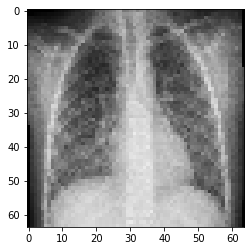

In [340]:
plt.imshow(test_images[89], cmap='gray', vmin=0, vmax=1)
plt.savefig('./89.png', dpi=300)

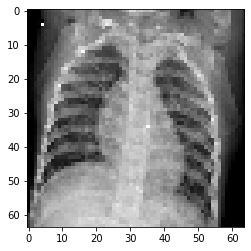

In [341]:
plt.imshow(test_images[294], cmap='gray', vmin=0, vmax=1)
plt.savefig('./294.png', dpi=300)

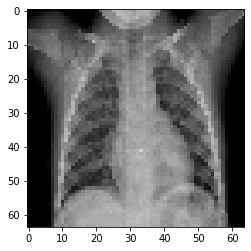

In [338]:
plt.imshow(test_images[371], cmap='gray', vmin=0, vmax=1)
plt.savefig('./371.png', dpi=300)

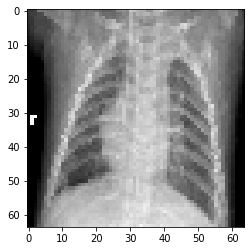

In [339]:
plt.imshow(test_images[555], cmap='gray', vmin=0, vmax=1)
plt.savefig('./555.png', dpi=300)

In [342]:
test_actually0 = compare_labels(pred_labels, test_labels, 0)

In [343]:
len(test_actually0)

68

In [344]:
len(imgs_test_normal)

234

In [345]:
68/234

0.2905982905982906

In [346]:
1- 68/234

0.7094017094017093

In [77]:
ninth_cnn = models.Sequential()

ninth_cnn.add(layers.Conv2D(filters=64, kernel_size=(4,4), padding='same', activation='relu', 
          input_shape=(64, 64, 1)))
ninth_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
ninth_cnn.add(layers.Conv2D(filters=64, kernel_size=(4,4), padding='same', activation='relu', 
                              kernel_regularizer= l2(l=0.001)))
ninth_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
#single dense layers
ninth_cnn.add(layers.Flatten())
ninth_cnn.add(layers.Dropout(0.5))
ninth_cnn.add(layers.Dense(64, activation='relu'))
#output layer
ninth_cnn.add(layers.Dense(1, activation='sigmoid'))

In [78]:
ninth_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 64, 64, 64)        1088      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 64)        65600     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16384)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)               

In [79]:
ninth_cnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

In [80]:
ninth_cnn.fit(train_images, train_labels, epochs=30, batch_size=100, validation_data=(val_images, val_labels), callbacks=[earlystop])

Epoch 1/30
42/42 [==============================] - 7s 164ms/step - loss: 0.5713 - accuracy: 0.7460 - recall_9: 0.9684 - val_loss: 0.4871 - val_accuracy: 0.7670 - val_recall_9: 0.9935
Epoch 2/30
42/42 [==============================] - 6s 150ms/step - loss: 0.3447 - accuracy: 0.8613 - recall_9: 0.9294 - val_loss: 0.4352 - val_accuracy: 0.8159 - val_recall_9: 0.9871
Epoch 3/30
42/42 [==============================] - 7s 164ms/step - loss: 0.2786 - accuracy: 0.8953 - recall_9: 0.9413 - val_loss: 0.2940 - val_accuracy: 0.8869 - val_recall_9: 0.9303
Epoch 4/30
42/42 [==============================] - 7s 171ms/step - loss: 0.2810 - accuracy: 0.8883 - recall_9: 0.9384 - val_loss: 0.3574 - val_accuracy: 0.8476 - val_recall_9: 0.8323
Epoch 5/30
42/42 [==============================] - 7s 167ms/step - loss: 0.2401 - accuracy: 0.9061 - recall_9: 0.9410 - val_loss: 0.2940 - val_accuracy: 0.8859 - val_recall_9: 0.9497
Epoch 6/30
42/42 [==============================] - 6s 151ms/step - loss: 0.2136

In [81]:
ninth_cnn.evaluate(train_images, train_labels)

131/131 [==============================] - 2s 11ms/step - loss: 0.1064 - accuracy: 0.9645 - recall_9: 0.9974


[0.10644062608480453, 0.9645339250564575, 0.9974193572998047]

In [76]:
ninth_cnn.evaluate(val_images, val_labels)

33/33 [==============================] - 1s 20ms/step - loss: 0.2149 - accuracy: 0.9204 - recall_8: 0.9432


[0.21493548154830933, 0.920421838760376, 0.9432258009910583]